<a href="https://colab.research.google.com/github/paulamartingonzalez/GNNs-cox/blob/main/version_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time to Event Prediction using Graph Neural Networks:



This is an extension of this [pycox tutorial with CNNs](https://nbviewer.jupyter.org/github/havakv/pycox/blob/master/examples/04_mnist_dataloaders_cnn.ipynb) to make it work with graph neural networks. It works with DGL at the moment

## Install and load packages

In [1]:
!pip install dgl 

In [2]:
!pip install pycox

In [3]:
!pip install torchtuples 

In [5]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader 

# MNIST is part of torchvision
from torchvision import datasets, transforms
from random import randint
import numpy as np
from dgl.nn import GraphConv
import torchtuples as tt
from pycox.models import LogisticHazard
from pycox.utils import kaplan_meier
from pycox.evaluation import EvalSurv
from torch.utils.data import DataLoader

Using backend: pytorch


In [6]:
tt.__version__

'0.2.1'

## Simulate data

### Time and event (y/n)

In [7]:
def sim_event_times(max_time=700):
    digits = []
    for _ in range(25):
        rnum = randint(0, 10)
        digits.append(float(rnum))
    digits = np.asarray(digits)
    betas = 365 * np.exp(-0.6 * digits) / np.log(1.2)
    event_times = np.random.exponential(betas)
    censored = event_times > max_time
    event_times[censored] = max_time

    return tt.tuplefy(event_times, ~censored)




In [8]:
sim_train = sim_event_times()
sim_test = sim_event_times()

In [9]:
labtrans = LogisticHazard.label_transform(20)
target_train = labtrans.fit_transform(*sim_train)
target_test = labtrans.transform(*sim_test)


### Create random graphs (with 20 nodes and 4 node features)

In [10]:
gs=[]
for i in range(25):
    g = dgl.graph((torch.randint(0, 20, (100,)), torch.randint(0, 20, (100,))), num_nodes=20)
    g = dgl.add_reverse_edges(g)
    g = dgl.remove_self_loop(g)
    #g = dgl.add_self_loop(g)
    g.ndata['h_n'] = torch.randn(g.num_nodes(), 4)
    
    gs.append((g,(torch.tensor(target_train[0][i]),torch.tensor(target_train[1][i])))) ## I don't know if this line is the best, when using tuplefy I was getting errors


In [19]:
gs_test=[]
for i in range(25):
    g = dgl.graph((torch.randint(0, 20, (100,)), torch.randint(0, 20, (100,))), num_nodes=20)
    g = dgl.add_reverse_edges(g)
    g = dgl.remove_self_loop(g)
    #g = dgl.add_self_loop(g)
    g.ndata['h_n'] = torch.randn(g.num_nodes(), 4)
    
    gs_test.append((g,(torch.tensor(target_train[0][i]),torch.tensor(target_train[1][i])))) ## I don't know if this line is the best, when using tuplefy I was getting errors


gs has shape: (graph,(time,event)),(graph,(time,event)),(graph,(time,event)),...

### Custom collate function

In [12]:
def collate(samples):
    graphs, labels = map(list, zip(*samples)) # you could just do zip(*samples)
    batched_graph = dgl.batch(graphs)
    return batched_graph, tt.tuplefy(labels).stack()

In [13]:
batch = [gs[0], gs[1]]
collate(batch)

(Graph(num_nodes=40, num_edges=370,
       ndata_schemes={'h_n': Scheme(shape=(4,), dtype=torch.float32)}
       edata_schemes={}), (tensor([19,  1]), tensor([0., 1.])))

### Dataloaders

In [20]:

data_loader = DataLoader(gs, batch_size=int(10), shuffle=True,
                            collate_fn=collate)
test_data_loader = DataLoader(gs_test, batch_size=int(10), shuffle=True,collate_fn=collate)

# Training

##  Define model

In [15]:
class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)
    def forward(self, g):
            in_feat = g.ndata['h_n'].float()
            h = self.conv1(g, in_feat)
            h = F.relu(h)
            h = self.conv2(g, h)
            g.ndata['h'] = h
            return dgl.mean_nodes(g, 'h')

In [16]:
net = GCN(4, 16, labtrans.out_features)
batch = next(iter(data_loader))
x, y = batch
net(x)

tensor([[-0.1323, -0.0322,  0.0072,  0.0513,  0.1739,  0.0656, -0.0375,  0.0339,
          0.0229,  0.0193, -0.0916, -0.1021,  0.0810,  0.1322,  0.0099,  0.2308,
          0.0263,  0.0408,  0.0701,  0.0878],
        [-0.1341,  0.0350, -0.0541,  0.1391,  0.0766, -0.1276,  0.0043, -0.1266,
          0.1179,  0.0843, -0.0161, -0.1277, -0.0249,  0.0224, -0.1235,  0.2072,
         -0.0333, -0.0569,  0.2435,  0.1244],
        [-0.0534,  0.0047,  0.0214,  0.0672,  0.0723,  0.0345, -0.0334, -0.0068,
          0.0163,  0.0484, -0.0381, -0.0541,  0.0590,  0.0404, -0.0313,  0.0960,
          0.0183,  0.0232,  0.0489,  0.0767],
        [-0.0693, -0.0233,  0.1089,  0.1549,  0.1284,  0.1439, -0.0558,  0.0181,
         -0.1272,  0.1113, -0.1910,  0.0213,  0.2531, -0.0197,  0.0337,  0.2590,
         -0.0054, -0.0412, -0.0189,  0.0436],
        [-0.1087,  0.0159, -0.0217,  0.1105,  0.0836, -0.0416, -0.0258, -0.0492,
          0.0717,  0.0934, -0.0229, -0.1015,  0.0470,  0.0804, -0.0845,  0.1120,
      

## Train

In [17]:
model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

In [21]:
callbacks = [tt.cb.EarlyStopping(patience=5)]
epochs = 50
verbose = True
log = model.fit_dataloader(data_loader, epochs, callbacks, verbose, val_dataloader=test_data_loader)

0:	[0s / 0s],		train_loss: 4.2466,	val_loss: 4.3092
1:	[0s / 0s],		train_loss: 3.9123,	val_loss: 3.6332
2:	[0s / 0s],		train_loss: 3.5425,	val_loss: 3.5008
3:	[0s / 0s],		train_loss: 4.0288,	val_loss: 3.4622
4:	[0s / 0s],		train_loss: 3.2572,	val_loss: 3.1081
5:	[0s / 0s],		train_loss: 3.4993,	val_loss: 2.9793
6:	[0s / 0s],		train_loss: 2.9546,	val_loss: 2.9687
7:	[0s / 0s],		train_loss: 2.9573,	val_loss: 2.9385
8:	[0s / 0s],		train_loss: 2.8590,	val_loss: 2.4759
9:	[0s / 0s],		train_loss: 2.2889,	val_loss: 2.5178
10:	[0s / 0s],		train_loss: 2.4740,	val_loss: 2.3840
11:	[0s / 0s],		train_loss: 2.0542,	val_loss: 2.3163
12:	[0s / 0s],		train_loss: 2.0000,	val_loss: 2.0555
13:	[0s / 0s],		train_loss: 1.9263,	val_loss: 2.1490
14:	[0s / 0s],		train_loss: 1.8472,	val_loss: 1.8966
15:	[0s / 0s],		train_loss: 1.6327,	val_loss: 1.9412
16:	[0s / 0s],		train_loss: 1.6751,	val_loss: 1.7208
17:	[0s / 0s],		train_loss: 1.7134,	val_loss: 1.9294
18:	[0s / 0s],		train_loss: 1.5540,	val_loss: 1.9609
19:

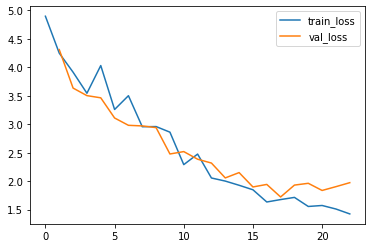

In [22]:
_ = log.plot()

# Define test set and evaluate performance

In [25]:
def collate_x(samples):
    graphs, labels = map(list, zip(*samples)) # you could just do zip(*samples)
    batched_graph = dgl.batch(graphs)
    return batched_graph

In [26]:
batch = [gs_test[0], gs_test[1]]
collate_x(batch)

Graph(num_nodes=40, num_edges=376,
      ndata_schemes={'h_n': Scheme(shape=(4,), dtype=torch.float32)}
      edata_schemes={})

In [28]:
test_data_loader_x = DataLoader(gs_test, batch_size=int(10), shuffle=True,collate_fn=collate_x)

In [31]:
model.predict(test_data_loader_x)

KeyError: ignored

In [29]:
surv = model.predict_surv_df(test_data_loader_x)

KeyError: ignored

In [30]:
surv = model.interpolate(10).predict_surv_df(test_data_loader_x)

KeyError: ignored

In [57]:
ev = EvalSurv(surv, *sim_test, 'km')

NameError: ignored

In [59]:
ev.concordance_td()

NameError: ignored